### Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("muted")
import scipy.stats as stats
%matplotlib inline
import scipy.stats as stats
from datetime import datetime as dt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#### Answer

In [2]:
import json

file = 'logins.json'
json_data = json.loads(open(file).read())
logins = []
for n in range(1, len(json_data['login_time'])):
    logins.append(json_data['login_time'][n])

In [3]:
df = pd.DataFrame(logins)
df.head()

,0
0,1970-01-01 20:16:10
1,1970-01-01 20:16:37
2,1970-01-01 20:16:36
3,1970-01-01 20:26:21
4,1970-01-01 20:21:41


In [4]:
df['times'] = df[0:]

In [5]:
df['times'] = df['times'].apply(lambda d: dt.strptime(d, '%Y-%m-%d %H:%M:%S'))
df['counter'] = 1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93141 entries, 0 to 93140
Data columns (total 3 columns):
0          93141 non-null object
times      93141 non-null datetime64[ns]
counter    93141 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.1+ MB


In [7]:
df = df.set_index('times')

In [8]:
df2 = pd.DataFrame(df['counter'])

In [9]:
sample = pd.DataFrame(df2.counter.resample('15T').sum())

In [10]:
sample.head()

,counter
times,
1970-01-01 20:00:00,1
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


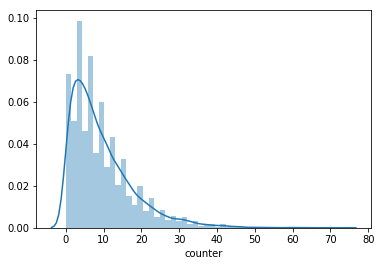

In [11]:
sns.distplot(sample.counter)

Text(0,0.5,'Daily mean number of logins per 15 minutes')

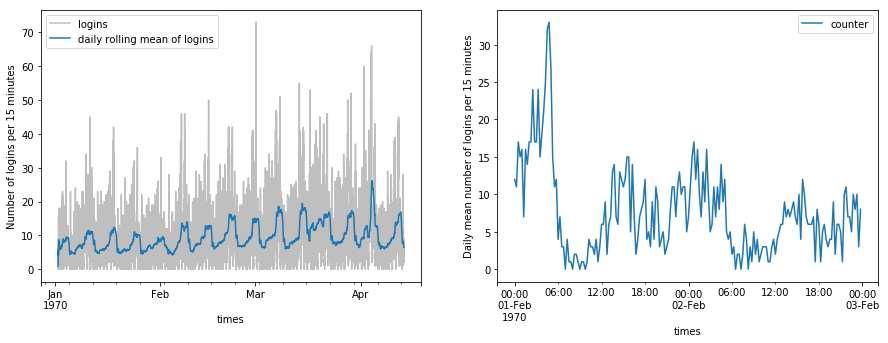

In [13]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15,5)
sample.counter.plot(ax=axes[0], alpha=0.5, c='grey', label='logins')
sample.counter.rolling('d').mean().plot(ax=axes[0], label='daily rolling mean of logins')
sample.loc['1970-02-01':'1970-02-02'].plot(ax=axes[1], label='mean logins')
axes[0].legend()
axes[0].set_ylabel('Number of logins per 15 minutes')
axes[1].set_ylabel('Daily mean number of logins per 15 minutes')

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    - how you will implement the experiment
    - what statistical test(s) you will conduct to verify the significance of the observation
    - how you would interpret the results and provide recommendations to the city operations team along with any caveats.


#### Answer
1. First, categorize drivers as predominantly Gotham or Metropolis drivers.  Then, based on this label, calculate % increase in pick ups in the non-dominant city. In the two categories, before and after toll increase, you could run a simple one-sided t-test to evaluate if there was an increase in other-city pick ups.
2. To control for variance due to different times that you would run into with option 1., above, is to only make tolls free for a subgroup of drivers in each city.  You could still use a t-test to evaluate difference among groups. If the goal is to encourage drivers to spend more time in both cities, a positive result (p>0.5) confirming an increase in other-city pickups would indicate the experiment worked, and implementation on a larger scale would likely acheive desired results.

### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. 

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


### Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

#### Answer

Step 1: Find retained users:  took a trip in the preceding 30 days from last timestamp (```last_trip_date```). Convert to indicator column (0,1). 

Step 2: Predict retained users in 6th month of membership with other available data.  